# Deep Unfolding applied to gradient descent
using: \
Julia 1.8.2 \
Flux.jl 0.13.6 \
Zygote.jl 0.6.49 \
Symbolics 5.10.0 \
\
In this Jupyter notebook, I explore applying Deep Unfolding (DU) to gradient descent algorithms. The notebook is based on Tadashi Wadayama's work found at https://github.com/wadayama/DU-Book/blob/main/Chapter_3/. What I do differently from Wadayama's notebook is the use of symbolic gradient for computing the gradient of the objective function (instead of hard-coding it) and trying out some other experiments than what is shown in his notebook.

Deep Unfolding treats iterative algorithms as if each iteration were a layer in a deep neural network. In this notebook, I consider applying DU to gradient descent, which iteratively modifies an input vector $x_k$ to minimize an objective function $f(x)$ using the recursive formula:

$$
x_{k+1} = x_k -\eta\cdot\nabla f(x_k),
$$

where $\nabla f(x)$ is the gradient of $f(x)$, and $\eta$ is the step size parameter. Here, $\eta$ is a parameter to be learned. 

I calculate $\nabla f(x)$ symbolically and use it in the recursive equation, converting it to a numerically evaluated function. Meanwhile, I calculate the gradient of the DU parameters (here just the scalar $\eta$) via automatic differentiation and optimize it using the Adam algorithm.

## A simple constant-parameter-learning example

In [153]:
using LinearAlgebra
using Plots
gr()
using Random
Random.seed!(1)
using Flux
using Zygote
using Symbolics

Define an objective function to minimize. We use Symbolics package to compute the gradient of the function.

In [154]:
@variables x[1:2]

#f(x)=(1-x[1])^2+100*(x[2]-x[1]^2)^2 # Rosenbrock function
f(x) = x[1]^2+x[2]^2 # Quadratic function

g(x)=Symbolics.gradient(f(x),Symbolics.get_variables(f(x))) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient
callable_gradient([1,1]) # sanity check

2-element Vector{Int64}:
 2
 2

Define a function that performs gradient descent. We will learn the step size $\eta$ or eta[1] (a scalar) using Deep Unfolding.

In [155]:
function GD_ki(max_itr, x0, eta)
    x = x0
    for i in 1:max_itr
        #df = gradient(() -> f(x), Flux.params(x)) 
        # The above line cannot be done because Flux.gradient cannot take gradient of itself.
        # We can hard-code df = 2*x or we can symbolically get the gradient and convert into a function 
        # returning numerical vector.
        
        x = x - eta[1].*callable_gradient(x)
    end
    return f(x)
end

GD_ki (generic function with 2 methods)

Define the train function that does the "deep unfolding". Here we perform automatic differentiation of the gradient descent algorithm using Flux.gradient. 

In [156]:
function train_ki(opt, eta, max_itr, train_itr) #training eta of gradient descent
    ps = Flux.params(eta) 
    l = [] # will keep record of eta values in this list
    for i in 1:train_itr # perform gradient descent starting from train_iter random starting points
        push!(l,eta[1]) # like append in python
        gs = Flux.gradient(ps) do
            GD_ki(max_itr, randn(2), eta) # perform gradient descent for max_itr iterations 
        end
        Flux.Optimise.update!(opt, ps, gs) # update ps = η train_iter times
    end  
    return l
end

train_ki (generic function with 1 method)

We plot the history of $\eta$ with respect to training iteration. The optimization algorithm employed is ADAM. It converges to the optimal value of $\eta = 0.5$ for the quadratic function.

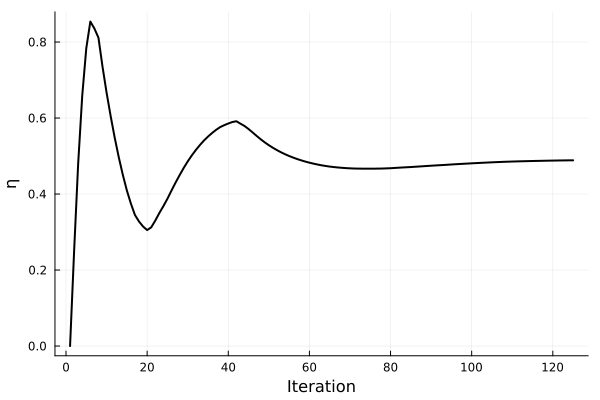

In [157]:
opt = Flux.ADAM(0.25) 
eta = [0.0]
max_itr = 2 # number of gradient descent iterations
train_itr = 125 # number of different starting point for gradient descent to update η
l = train_ki(opt, eta, max_itr, train_itr)
plot(1:train_itr,l, xlabel="Iteration", ylabel="η",legend=false, lw=2,color=:black)

## A Second Quadratic Function Descent Example

In [176]:
n = 100 #number of dimension of the quadratic function (the objective function)
num_itr = 30 #number of iteration for the gradient descent to show on plots
train_itr = 25 # number of increments in incremental learning
K = 50 #batch size
adam_lr = 1e-3 #learning rate for ADAM algorithm to learn eta
max_inner = 20 #number of batches

20

In [159]:
A = diagm(1:n)
#println(A)
λmin = 1
λmax = n
ηopt = 1/(λmin + λmax)

0.009900990099009901

In [160]:
@variables x[1:n]
x=Symbolics.scalarize(x)
f(x)= x'*A*x

g(x)=Symbolics.gradient(f(x),[x[i] for i in 1:n]) # compute symbolically the gradient of f(x)

g_expr = build_function(g(x),x) 
callable_gradient=eval(g_expr[1]) # we obtain a function that returns a numerical gradient



#185 (generic function with 1 method)

As a benchmark we compute fixed-step-size gradient descent.

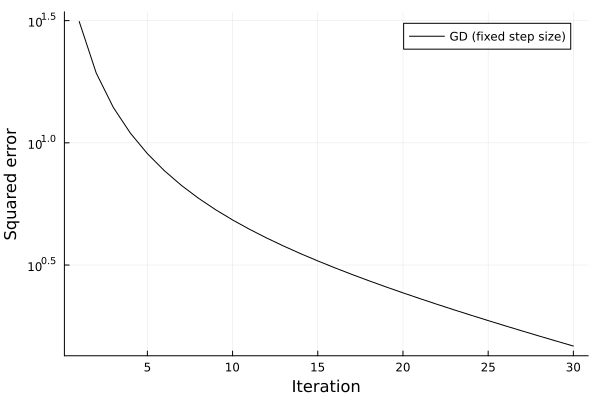

In [161]:
function GD_ki(max_itr, x0)
    x = x0
    for i in 1:max_itr
        #x = x - ηopt*2*A*x
        x = x - ηopt*callable_gradient(x)
    end
    return x
end

function comp_se(max_itr,x0)
    x̂ = GD_ki(max_itr, x0)
    return norm(x̂)^2
end

xinit = randn(n)
GD_mse = [comp_se(i,xinit) for i in 1:num_itr]
plot(1:num_itr, GD_mse, lw=1, yscale=:log10, label="GD (fixed step size)", color=:black,  xlabel="Iteration", ylabel="Squared error")


The following is a deep-unfolding-gradient-descent algorithm that has cyclic vairable step-sizes $\eta$ with period T.

In [162]:
function DU_GD_ki(max_itr, x0, η, T)
    x = x0
     
    for i in 0:max_itr-1
        k = (i % T)+1
        #x = x - η[k]*A*x
        if isa(x, Matrix)
            array_x = [callable_gradient(x[:,j]) for j in 1:K]
            x = x - η[k]*hcat(array_x...)
        else isa(x, Vector)
            x = x - η[k]*callable_gradient(x)
        end
    end
    return x
end

DU_GD_ki (generic function with 1 method)

In [163]:
function g_sa(x, func, ck, niter=1, args...)
    p = length(x)
    gsum = zeros(p)
    yp = 0.0
    ym = 0.0
    xp = copy(x)
    xm = copy(x)
    delta = zeros(p)

    if niter > 0
        buf=Zygote.Buffer(delta, p, niter)
        for m in 1:niter
            delta = 2 .* floor.(2 .* rand(p)) .- 1

            xp = x + ck .* delta
            xm = x - ck .* delta
            yp = func(xp, args...)
            ym = func(xm, args...)
            buf[:,m] = (yp - ym) ./ (2 * ck .* delta)
        end
        gsum=sum(copy(buf),dims=2)
        ghat = gsum / niter
    else
        ghat = zeros(p)
    end
    # return ghat, yp, ym, xp, xm, delta
    return ghat
end


g_sa (generic function with 2 methods)

In [164]:
function DU_SPSA(func, max_itr, x0, η, T)
    x = x0
    #println("is x a Vector? ",isa(x, Vector))
    gamma = 0.101
    alpha=0.602
    c = 1.0e-6
    A = Int(floor(0.1 * max_itr))
    
    for i in 0:max_itr-1
        k = (i % T)+1
        ck = c / (i + 1)^gamma
        ak = η[k] / (i + 1 + A)^alpha
        #x = x - η[k]*A*x
        if isa(x, Matrix)
            #println("x is a Matrix")
            array_x = [g_sa(x[:,j],func,ck) for j in 1:K]
            x = x - η[k]*hcat(array_x...)
        else isa(x, Vector)
            #println("x is a Vector")
            x = x - η[k]*g_sa(x,func,ck)
            x=vec(x)
            #println("x = ",x)
        end
    end
    return x
end

DU_SPSA (generic function with 1 method)

The loss function to be used in the training algorithm is a mean square error of K trials (in other words, K is the batch size).

In [165]:
function loss(x̂)
    return norm(x̂)^2/K #this is the error of the batch
end 

loss (generic function with 1 method)

The training algorithm defined below takes the automatic gradient of the deep-unfolding-gradient-descent algorithm

In [166]:
function train(opt, η, T, train_itr)
    ps = Flux.params(η) 
    for itr in 1:train_itr
        for i in 1:max_inner
            x0 = randn(n,K)
            gs = Flux.gradient(ps) do
                x_est = DU_GD_ki(itr, x0, η, T)
                #x_est = DU_SPSA(f,itr, x0, η, T)
                loss(x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        x0 = randn(n,K)
        x_est = DU_GD_ki(itr, x0, η, T)
        #x_est = DU_SPSA(f,itr, x0, η, T)
        println(itr, " ", loss(x_est))
    end
end

train (generic function with 1 method)

In [167]:
function comp_se_DUGD(max_itr, x0, η, T)
    x_est = DU_GD_ki(max_itr, x0, η, T)
    #x_est = DU_SPSA(f,max_itr, x0, η, T)
    return loss(x_est)
end

comp_se_DUGD (generic function with 1 method)

The $\eta$ is now trained (learned) as if it were a weight in deep learning algorithms, as iterations are viewed as equivalent of layers in deep neural networks.
The $\eta$ takes cyclic values of period T, which means that it is a vector of length T.

1 67.49089084762188
2 34.19119068408311
3 18.41118611761873
4 11.723816031666832
5 8.308170204748116
6 6.497623379196697
7 5.41655908771863
8 4.052943625979862
9 4.235468873503929
10 3.0846189252167067
11 2.702889394994138
12 2.1440950469201194
13 2.0818936120823297
14 1.9737005754113925
15 1.9027033715670254
16 1.7819934533541646
17 1.3821250946748298
18 1.2820989523698523
19 1.2418932034813597
20 0.9311766349499819
21 0.906933599292577
22 0.9316002867323075
23 0.8391883451842429
24 0.9568790739619036
25 0.6835217898830538


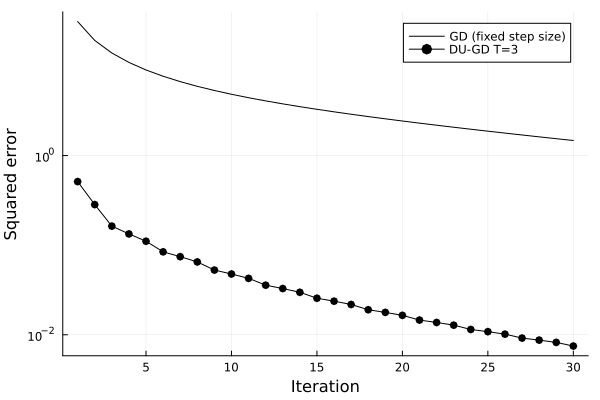

In [168]:
T = 3
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train, T, train_itr)
#println("is xinit a matrix?",isa(xinit, Matrix))
DUGD_mse =[comp_se_DUGD(i, xinit, η_train, T) for i in 1:num_itr]
opt_param1 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse, lw=1, label="DU-GD T="*string(T), color=:black, marker=:o)

1 64.50292320377534
2 33.14515468805591
3 20.36237567270754
4 12.05066849400278
5 8.455465851202268
6 5.975444212497812
7 4.868867992430088
8 4.127255749989379
9 2.9160071011936153
10 2.8286690205017027
11 2.595052212771957
12 1.6918287708418027
13 1.9809156686867753
14 1.4849571124741265
15 1.1302804904614252
16 1.2708620565803848
17 1.0724392057983427
18 0.9887311757467026
19 0.9937019672348809
20 0.7362534661852268
21 0.875881374225525
22 0.6173779401039371
23 0.7450775912536493
24 0.49938796998460466
25 0.5426189840322533


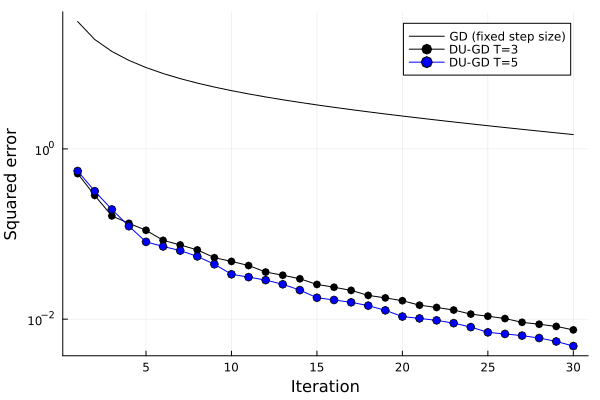

In [169]:
T = 5
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train(opt, η_train, T, train_itr)
DUGD_mse2 =[comp_se_DUGD(i, xinit, η_train, T) for i in 1:num_itr]
opt_param2 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUGD_mse2, lw=1, label="DU-GD T="*string(T), color=:blue, marker=:o)

In [170]:
function train_spsa(opt, η, T, train_itr)
    ps = Flux.params(η) 
    for itr in 1:train_itr
        for i in 1:max_inner
            x0 = randn(n,K)
            gs = Flux.gradient(ps) do
                #x_est = DU_GD_ki(itr, x0, η, T)
                x_est = DU_SPSA(f,itr, x0, η, T)
                loss(x_est)
            end
            Flux.Optimise.update!(opt, ps, gs)
        end
        x0 = randn(n,K)
        #x_est = DU_GD_ki(itr, x0, η, T)
        x_est = DU_SPSA(f,itr, x0, η, T)
        println(itr, " ", loss(x_est))
    end
end

train_spsa (generic function with 1 method)

In [171]:
function comp_se_DUSPSA(max_itr, x0, η, T)
    #x_est = DU_GD_ki(max_itr, x0, η, T)
    x_est = DU_SPSA(f,max_itr, x0, η, T)
    return loss(x_est)
end

comp_se_DUSPSA (generic function with 1 method)

1 111.62401240627779
2 97.78311868382798
3 111.30237125616772
4 96.8009643381589
5 98.22216785210348
6 97.39724414966247
7 98.71219725850055
8 97.02902480636654
9 93.95456716447286
10 95.72024651034786
11 96.95311444764948
12 88.0772803582929
13 1.4196113944876094e12
14 19764.657184128922
15 4.564688092773987e13
16 4.805086243069232e21
17 1.6237575916081754e21
18 3.377356526245151e17
19 1.422170656320524e16
20 1.0624961319327023e19
21 2.3848489730208976e20
22 4.966255144866133e18
23 2.5585941442002924e18
24 1.8420311151119585e15
25 5.178641338199987e16


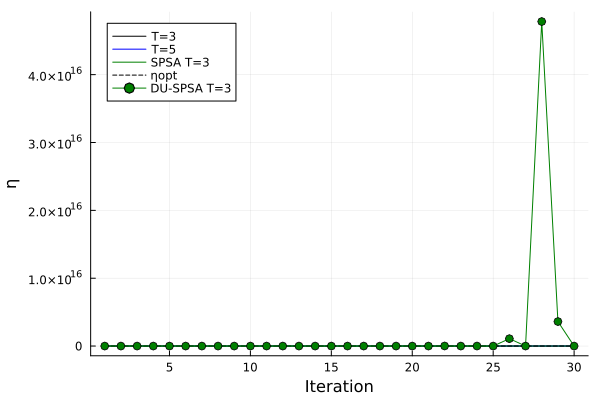

In [177]:
T = 3
η_train = zeros(num_itr) 
opt = Flux.ADAM(adam_lr) 
train_spsa(opt, η_train, T, train_itr)
#println("is xinit a matrix?",isa(xinit, Matrix))
DUSPSA_mse =[comp_se_DUSPSA(i, xinit, η_train, T) for i in 1:num_itr]
opt_param3 = [η_train[(i%T)+1] for i in 0:num_itr-1]
plot!(1:num_itr, DUSPSA_mse, lw=1, label="DU-SPSA T="*string(T), color=:green, marker=:o)

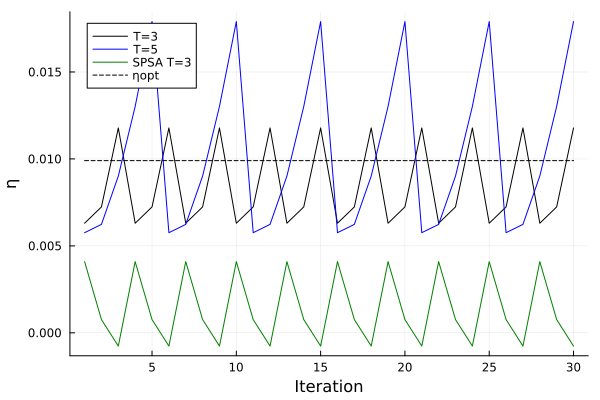

In [178]:
plot(1:num_itr, opt_param1, lw=1, label="T=3", color=:black, ls=:solid, xlabel="Iteration", ylabel="η")
plot!(1:num_itr, opt_param2, lw=1, label="T=5", color=:blue, ls=:solid)
plot!(1:num_itr, opt_param3, lw=1, label="SPSA T=3", color=:green, ls=:solid)
plot!(1:num_itr, x->ηopt, lw=1, label="ηopt", color=:black, ls=:dash)

In [174]:
DU_SPSA(f, 3, xinit, η_train, T)

100-element Vector{Float64}:
  0.8045719964550069
  0.8599502294878975
 -0.4322248360111597
 -1.8065093726529922
 -0.8335324915770894
 -0.9406471090176587
 -0.22567666603145714
  1.5954995011528457
 -1.5336925917362518
  1.1273552288159816
 -0.299966349605437
 -0.3817782511169665
  0.5211273792210206
  ⋮
  1.372692664164169
  0.4116114995722079
  1.1753010550236933
  1.2710834123813066
  0.746046781060738
 -0.7263520350491985
  0.18909743787600697
 -0.39509263687653473
  0.21278048524403892
 -0.7763285746377215
  0.3390947967897035
 -2.0740812284381076